In [14]:
import sys, os

# add TriplePandelReco directory to $PYTHONPATH.
sys.path.insert(0, "/home/storage/hans/jax_reco_gupta_corrections3")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# load jax and make sure we use double precision
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
# also need quick access to normal distribution
from jax.scipy.stats import norm as jnorm

# import network logic.
from lib.gupta_network_eqx_4comp import get_network_eval_fn

# import some required coordinate transformations
# see e.g. https://github.com/HansN87/TriplePandelReco_JAX/blob/gupta_4comp/dom_track_eval.py 
# for how these would be used in practice during reconstruction
from lib.trafos import transform_network_inputs
from lib.trafos import transform_network_outputs_gupta_4comp as transform_network_outputs

# import pdf and cdf of mixture of gupta distributions.
from lib.gupta import multi_gupta_pdf
from lib.gupta import multi_gupta_cdf

# we also want some plotting and other standard libraries
import numpy as np
import matplotlib.pyplot as plt

# and a special library for numerical integration in jax
# that we can use to make comparisons to.
from quadax import quadgk as jquad

In [30]:
# generate network evaluation logic (gupta with 4 components) based on weights from TriplePandelReco data directory
# again: double precision.
dtype = jnp.float64

path_to_reco = '/home/storage/hans/jax_reco_gupta_corrections3/'

eval_network = get_network_eval_fn(bpath=os.path.join(path_to_reco, 'data/gupta/n96_4comp/new_model_no_penalties_tree_start_epoch_800.eqx'), dtype=dtype, n_hidden=96)

In [124]:
# here are some coordinates
#dist = 30.0 # m

dist = 2
z = -500.0 # m
rho = 0.0 # radians
zenith = jnp.pi/2 # radians
azimuth = 0.0 # radians

x = jnp.array([dist, rho, z, zenith, azimuth])

# which we can now map to our pdf parameters (4-comp gupta) via the neural network
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gupta_a, gupta_b = transform_network_outputs(y)
mix_probs = jax.nn.softmax(logits)

In [125]:
print(mix_probs)
print(gupta_a)
print(gupta_b)

[0.09171425 0.82992147 0.06047874 0.01788553]
[ 2.08854539 12.13879193  1.0292246   1.00008829]
[6.52621153e-01 6.26274300e+00 3.33060560e-02 2.31785079e-03]


Text(0.5, 0, 'delay time [ns]')

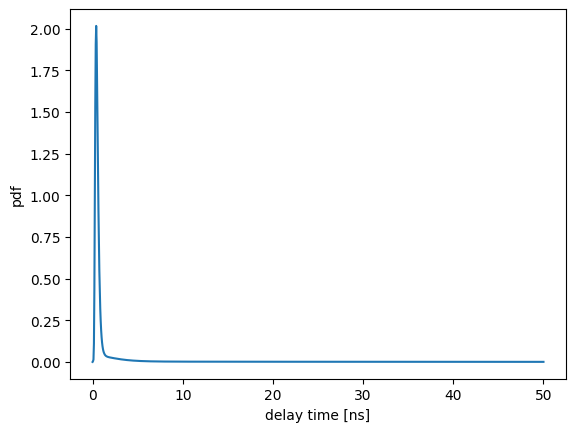

In [126]:
# make a plot of the gupta pdf for the chosen coordinates

delay_times = jnp.linspace(0.0, 50.0, 1000)
plt.plot(delay_times, multi_gupta_pdf(delay_times, mix_probs, gupta_a, gupta_b))
plt.ylabel("pdf")
plt.xlabel("delay time [ns]")

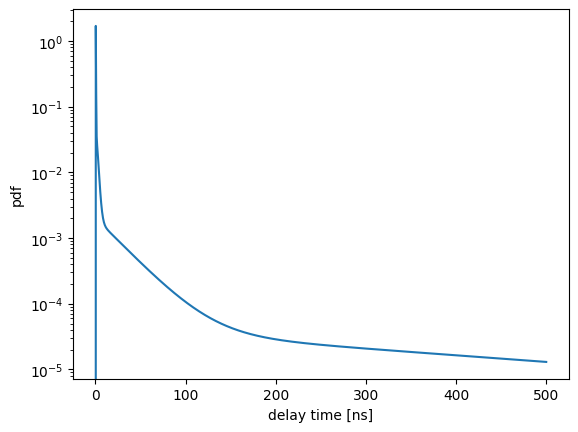

In [127]:
# and on log-scale

delay_times = jnp.linspace(0.0, 500.0, 1000)
plt.plot(delay_times, multi_gupta_pdf(delay_times, mix_probs, gupta_a, gupta_b))
plt.ylabel("pdf")
plt.xlabel("delay time [ns]")
plt.yscale('log')

In [128]:
# make a plot of the gupta cdf for the chosen coordinates

(0.0, 1.0)

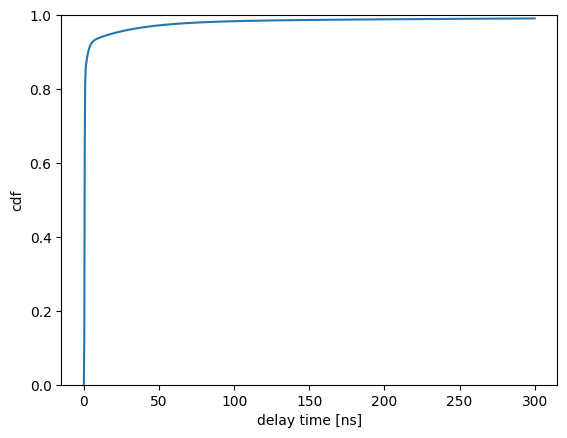

In [129]:
delay_times = jnp.linspace(0.0, 300.0, 1000)
plt.plot(delay_times, multi_gupta_cdf(delay_times, mix_probs, gupta_a, gupta_b))
plt.ylabel("cdf")
plt.xlabel("delay time [ns]")
plt.ylim([0.0, 1.0])

Text(0.5, 0, 'delay time [ns]')

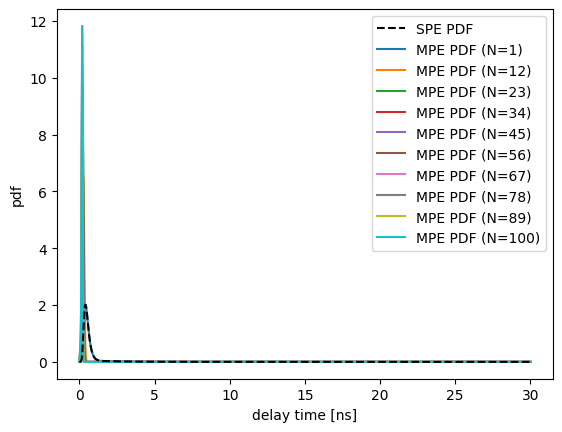

In [130]:
# However, during reconstruction we are more interested in the MPE pdf, the pdf that describes the earliest time 
# in a random sample of a given size N (total charge for us). This is known as "first order statistic".
# https://en.wikipedia.org/wiki/Order_statistic

# a gaussian-convolved version of this is implemented here
# https://github.com/HansN87/TriplePandelReco_JAX/blob/76bcbb5c1ad5e98b4b027e73e4ee7b0af7dbd4c9/lib/gupta.py#L191
# but for now we just code a version without convolution.

# Note: we use naive implementations here. For the real thing, one would pay attention to numerical stability
# e.g. see https://github.com/HansN87/TriplePandelReco_JAX/blob/66bf606a0b7dec29efc44512978bfd2c5d0194a2/lib/gupta.py#L81

def multi_gupta_mpe_pdf(x, mix_probs, a, b, n):
    pdf_vals = multi_gupta_pdf(x, mix_probs, a, b)
    cdf_vals = multi_gupta_cdf(x, mix_probs, a, b)
    return n * pdf_vals * jnp.power(1.-cdf_vals, n-1)


delay_times = jnp.linspace(0.0, 30.0, 1000)
n_photons = jnp.array(np.linspace(1, 100, 10))

# we first plot the standard pdf (SPE)
ys = multi_gupta_pdf(delay_times, mix_probs, gupta_a, gupta_b)
plt.plot(delay_times, ys, "k--", zorder=100, label='SPE PDF')

y_max = np.max(ys)
for n_p in n_photons:
    ys = multi_gupta_mpe_pdf(delay_times, mix_probs, gupta_a, gupta_b, n_p)
    plt.plot(delay_times, 
             ys, 
             label=f'MPE PDF (N={n_p:.0f})')
    
    y_max = np.max([y_max, np.max(ys)])

plt.legend()
plt.ylabel("pdf")
plt.xlabel("delay time [ns]")

In [144]:
# and now let's play with gaussian convolution.
# where width is controlled by sigma parameter

# convolution is an integration like 
# fconv(t) = int f(x) * g(t-x) dx

# for demonstration: perform this via numeric integration ala quad.

def integrand(x, mix_probs, a, b, n, sigma, t):
    return jnorm.pdf(x, loc=t, scale=sigma) * multi_gupta_mpe_pdf(x, mix_probs, a, b, n)

def convolved_mpe_pdf(t, mix_probs, a, b, n, sigma):
    # define integration range in units of sigma
    delta = jnp.array(15) # units of sigma
    # and stay away from x = 0
    eps = jnp.array(1.e-12)
    
    xmax = jnp.max(jnp.array([delta*sigma, t + delta*sigma]))
    diff = xmax-t
    xmin = jnp.max(jnp.array([jnp.array(0.0)+eps, t - diff]))
    
    res = jquad(integrand, 
                 jnp.array([xmin, 0.1, 1.0, xmax]), 
                 args=(mix_probs, a, b, n, sigma, t), 
                 epsabs=1.e-5, 
                 epsrel=1.e-5, 
                 order=31,
                 max_ninter=10
              )[0]
    
    return res

# in order to make a plot of the convolved pdf it is convenient to vectorize the function
# over the time argument (the argument in 0-th position)
# rather than evaluating it in a loop over points in time

convolved_mpe_pdf_v = jax.jit(jax.vmap(convolved_mpe_pdf, (0, None, None, None, None, None), 0))

Text(0.5, 0, 'delay time [ns]')

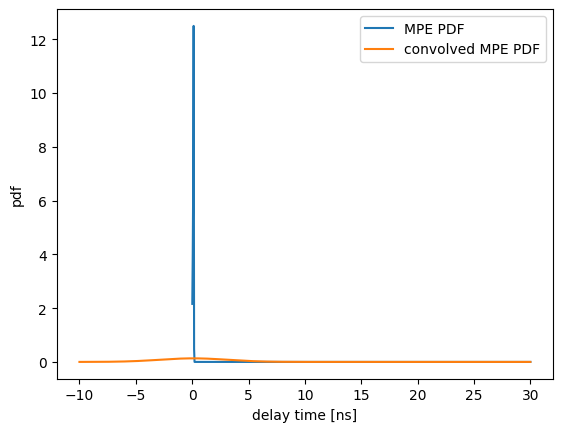

In [145]:
delay_times = jnp.linspace(-10.0, 30.0, 1000) # note: we now allow negative times
# reminder: the original PDF does not have support for negative values.

# assume 10 photons
n_p = jnp.array(1000)
# and 3ns convolution
sigma = jnp.array(3.0)

ys_orig = multi_gupta_mpe_pdf(delay_times, mix_probs, gupta_a, gupta_b, n_p)
ys_conv = convolved_mpe_pdf_v(delay_times, mix_probs, gupta_a, gupta_b, n_p, sigma)

plt.plot(delay_times, ys_orig, label='MPE PDF')
plt.plot(delay_times, ys_conv, label='convolved MPE PDF')
plt.legend()
plt.ylabel("pdf")
plt.xlabel("delay time [ns]")

In [146]:
# let's verify that the convolved MPE PDF has correct normalization (unity)
# we simply integrate 

# jit compile for faster integration
convolved_mpe_pdf_jit = jax.jit(convolved_mpe_pdf)

norm_mpe = jquad(convolved_mpe_pdf_jit, 
                 jnp.array([-20, 200]), 
                 args=(mix_probs, gupta_a, gupta_b, n_p, sigma), 
                 epsabs=1.e-5, 
                 epsrel=1.e-5, 
                 order=31,
                 max_ninter=10
              )[0]

print(norm_mpe)

1.0000015305197618


In [147]:
# the integration above uses a quadrature scheme.
# This can be slow (If you have ideas how to make it faster? Great!). 
# As an alternative, we can come up with a discrete integration scheme, e.g. midpoint.

def convolved_mpe_pdf_midpoint(x, mix_probs, a, b, n, sigma):
    # let's define some interval edges that will lead to mid points.
    # It's useful to always have some dense support points near t=0,
    # because that's where the MPE pdfs will produce a sharp peak when n -> large.
    eps = 1.e-6
    xvals0 = jnp.linspace(eps, 1.e-2, 10)
    xvals1 = jnp.linspace(1.e-2, 1.e-1, 10)
    xvals2 = jnp.linspace(1.e-1, 1.0, 10)
    xvals3 = jnp.linspace(1.0, 10.0, 10)
    
    # then we place the majority of support points within some range, e.g. 10 in 
    # units of sigma around the gaussian (centered on x)
    xmin = jnp.max(jnp.array([1.1*eps, x - 10 * sigma])) # can't have two support points on the same position
    xmax = jnp.max(jnp.array([xmin+1.5*eps, x + 10 * sigma]))
    xvals4 = jnp.linspace(xmin, xmax, 100)
    
    xvals = jnp.sort(jnp.concatenate([xvals0, xvals1, xvals2, xvals3, xvals4])) # edges need to be in sorted order
    dx = xvals[1:]-xvals[:-1]
    xvals = 0.5*(xvals[:-1]+xvals[1:]) # get mid points
    
    return jnp.sum(dx * jnorm.pdf(x, loc=xvals, scale=sigma) * multi_gupta_mpe_pdf(xvals, mix_probs, a, b, n))
    
print(convolved_mpe_pdf_midpoint(-1.0, mix_probs, gupta_a, gupta_b, n_p, sigma)) 

# vectorize over t
convolved_mpe_pdf_midpoint_v = jax.jit(jax.vmap(convolved_mpe_pdf_midpoint, (0, None, None, None, None, None), 0))

0.12353969789668728


Text(0.5, 0, 'delay time [ns]')

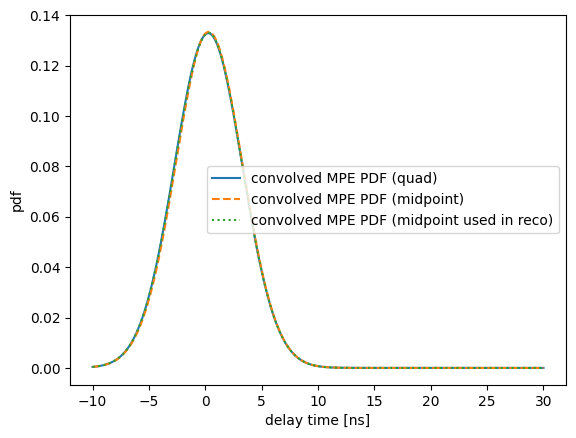

In [148]:
# Let's compare both version (numeric integration and midpoint) to what we use during reconstruction (another midpoint)
from lib.gupta import c_multi_gupta_mpe_logprob_midpoint2_stable
c_multi_gupta_mpe_logprob_midpoint2_stable_v = jax.jit(jax.vmap(c_multi_gupta_mpe_logprob_midpoint2_stable, (0, None, None, None, None, None), 0))

delay_times = jnp.linspace(-10.0, 30.0, 1000) # note: we now allow negative times
# reminder: the original PDF does not have support for negative values.

# assume 10 photons
n_p = jnp.array(10)
# and 3ns convolution
sigma = jnp.array(3.0)

ys_orig = multi_gupta_mpe_pdf(delay_times, mix_probs, gupta_a, gupta_b, n_p) # original
ys_conv = convolved_mpe_pdf_v(delay_times, mix_probs, gupta_a, gupta_b, n_p, sigma) # numeric conv via quad
ys_conv_midpoint = convolved_mpe_pdf_midpoint_v(delay_times, mix_probs, gupta_a, gupta_b, n_p, sigma) # numeric conv via midpoint
ys_conv_midpoint2 = jnp.exp(c_multi_gupta_mpe_logprob_midpoint2_stable_v(delay_times, jnp.log(mix_probs), gupta_a, gupta_b, n_p, sigma)) # numeric conv via midpoint

#plt.plot(delay_times, ys_orig, label='MPE PDF')
plt.plot(delay_times, ys_conv, label='convolved MPE PDF (quad)')
plt.plot(delay_times, ys_conv_midpoint, label='convolved MPE PDF (midpoint)', linestyle='dashed')
plt.plot(delay_times, ys_conv_midpoint2, label='convolved MPE PDF (midpoint used in reco)', linestyle='dotted')

plt.legend()
plt.ylabel("pdf")
plt.xlabel("delay time [ns]")

In [152]:
delay_times = jnp.linspace(-10.0, 30.0, 1000000)

In [153]:
%timeit convolved_mpe_pdf_v(delay_times, mix_probs, gupta_a, gupta_b, n_p, sigma).block_until_ready()

1.56 s ± 378 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [154]:
%timeit convolved_mpe_pdf_midpoint_v(delay_times, mix_probs, gupta_a, gupta_b, n_p, sigma).block_until_ready()

443 ms ± 683 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
